<a href="https://colab.research.google.com/github/vjnbarot/datasharing/blob/master/DataWarehousing_Netflix_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read-in data and descibe

In [ ]:
!rm -rf /root/nltk_data/tokenizers/punkt
!python -m nltk.downloader punkt

!pip install pycountry


<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import seaborn as sns


from wordcloud import WordCloud
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose


# # Read-in data and descibe

df = pd.read_csv('https://raw.githubusercontent.com/JessicaFaulk/Data-Warehousing/refs/heads/main/netflix_titles.csv')

In [ ]:
df.describe()

release_year
count   8807.000000
mean    2014.180198
std        8.819312
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2019.000000
max     2021.000000

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [ ]:
print("duplicated values:", df.duplicated().sum())

duplicated values: 0


In [ ]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() * 100 / len(df)

# Print the results
missing_percentage


show_id          0.000000
type             0.000000
title            0.000000
director        29.908028
cast             9.367549
country          9.435676
date_added       0.113546
release_year     0.000000
rating           0.045418
duration         0.034064
listed_in        0.000000
description      0.000000
dtype: float64

In [ ]:
df.head(5)

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

Intial review indicates that the duration column is not consistent. Some are in minutes (for movies) and some are in seasons.

# Data Cleaning and Munging

In [ ]:
print(df['country'].value_counts())

country
United States                                                      2818
India                                                               972
United Kingdom                                                      419
Japan                                                               245
South Korea                                                         199
                                                                   ... 
Mexico, United States, Spain, Colombia                                1
Canada, Norway                                                        1
Finland, Germany, Belgium                                             1
Argentina, United States, Mexico                                      1
United Kingdom, United States, Germany, Denmark, Belgium, Japan       1
Name: count, Length: 748, dtype: int64


##Handle missing values, duplicates and convert date_added to datetime

In [ ]:
#Drop duplicated rows if found (we confirmed there are none but is good to just do)
df.drop_duplicates(inplace=True)

In [ ]:

# Calculate the percentage of rows with any missing data
rows_with_missing_data = df.isnull().any(axis=1).sum()
total_rows = len(df)
percentage_missing_rows = (rows_with_missing_data / total_rows) * 100

print(f"Percentage of rows with missing data: {percentage_missing_rows:.2f}%")


Percentage of rows with missing data: 39.46%


In [ ]:
# prompt: drop the cast and director column

# Drop the 'cast' and 'director' columns
df = df.drop(['cast', 'director'], axis=1)


In [ ]:

# Calculate the percentage of rows with any missing data
rows_with_missing_data = df.isnull().any(axis=1).sum()
total_rows = len(df)
percentage_missing_rows = (rows_with_missing_data / total_rows) * 100

print(f"Percentage of rows with missing data: {percentage_missing_rows:.2f}%")

Percentage of rows with missing data: 9.61%


In [ ]:
# Replace missing values with UNK for anything that is not numeric, int, or a date

#df['director'].fillna('Unknown', inplace=True)  # Replace missing directors with 'Unknown'.  ...drop
#df['cast'].fillna('Unknown', inplace=True)  # Replace missing cast with 'Unknown'.  ...drop
#df['country'].fillna('Unknown', inplace=True)  # Replace missing country with 'Unknown' ...drop
#df['duration'].fillna('Unknown', inplace=True)  # Replace missing duration with 'Unknown' ...maybe drop
#df['rating'].fillna('Unknown', inplace=True) # Replace missing rating with 'Unknown'
#df = df.dropna(subset=['date_added']) # Drops rows with missing date added
df.dropna(inplace=True)

In [ ]:
df.shape

(7961, 10)

In [ ]:
#format date_added correctly for time series analysis
df['date_added'] = pd.to_datetime(df['date_added'].str.strip(), format='%B %d, %Y', errors='coerce')

# add a column that has the only the year from date added
df['year_added'] = df['date_added'].dt.year


# Extract month and year, then combine them into a new column
df['month_year_added'] = df['date_added'].dt.strftime('%Y-%m')

## Split duration into num values

In [ ]:
# Split the duration column so that duration_num contains only the numeric value

df['duration_num'] = df['duration'].str.extract('(\d+)').astype(float)

## Explode the list from "listed_in" to a new frame

In [ ]:
df['listed_in'] = df['listed_in'].str.split(', ')  # Split the genres into lists
df_exploded = df[['show_id', 'type', 'listed_in']].explode('listed_in')
df_exploded.head()

show_id     type               listed_in
0      s1    Movie           Documentaries
1      s2  TV Show  International TV Shows
1      s2  TV Show               TV Dramas
1      s2  TV Show            TV Mysteries
4      s5  TV Show  International TV Shows

Clean up ratings categories

In [ ]:

# Create the pivot table
pivot_table = pd.pivot_table(df, values='show_id', index='rating', columns='type', aggfunc='count', fill_value=0)

# Display the table
pivot_table

type      Movie  TV Show
rating                  
G            41        0
NC-17         3        0
NR           75        4
PG          281        0
PG-13       482        0
R           787        1
TV-14      1307      620
TV-G        109       81
TV-MA      1924     1005
TV-PG       504      267
TV-Y         84      143
TV-Y7        83      152
TV-Y7-FV      4        1
UR            3        0

In [ ]:
# Define the list of valid ratings
valid_ratings = {'PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
                 'TV-G', 'G', 'NC-17', 'NR', 'Unknown', 'TV-Y7-FV', 'UR'}


# Remove rows with invalid ratings
df = df[df['rating'].isin(valid_ratings)]

# Define rating categories
younger_ratings = {'G', 'PG', 'TV-Y', 'TV-Y7', 'TV-PG'}
older_ratings = {'PG-13', 'R', 'TV-MA', 'TV-14', 'NC-17'}
unrated_ratings = {'NR', 'Unknown', 'UR'}

# Function to categorize ratings
def categorize_rating(rating):
    if rating in younger_ratings:
        return 'younger'
    elif rating in older_ratings:
        return 'older'
    elif rating in unrated_ratings:
        return 'unrated'
    else:
        return 'unrated'  # In case of any unexpected values

# Apply the function to the 'rating' column
df['rating'] = df['rating'].apply(categorize_rating)

# Verify the changes by counting the number of occurrences in each category
df['rating'].value_counts()


rating
older      6129
younger    1555
unrated     277
Name: count, dtype: int64

In [ ]:
df.describe()

date_added  release_year   year_added  duration_num
count                           7961   7961.000000  7961.000000   7961.000000
mean   2019-04-19 01:14:53.103881472   2013.888079  2018.796634     72.331617
min              2008-01-01 00:00:00   1942.000000  2008.000000      1.000000
25%              2018-03-15 00:00:00   2013.000000  2018.000000      3.000000
50%              2019-06-15 00:00:00   2017.000000  2019.000000     90.000000
75%              2020-07-03 00:00:00   2019.000000  2020.000000    107.000000
max              2021-09-25 00:00:00   2021.000000  2021.000000    312.000000
std                              NaN      8.963881     1.562747     50.134358

# Intial Analysis

In [ ]:
# Composition of the file for TV and Movies
type_percent = df['type'].value_counts(normalize=True) * 100
print(type_percent)

type
Movie      71.435749
TV Show    28.564251
Name: proportion, dtype: float64


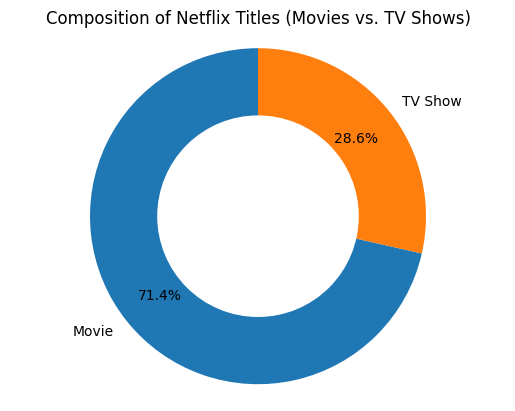

In [ ]:
# Create the doughnut chart
labels = type_percent.index
sizes = type_percent.values

fig, ax = plt.subplots()
ax.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.75)

# Draw a circle at the center of the plot to create a doughnut chart
centre_circle = plt.Circle((0, 0), 0.6, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures the circle is circular
ax.axis('equal')

plt.title('Composition of Netflix Titles (Movies vs. TV Shows)')
plt.show()


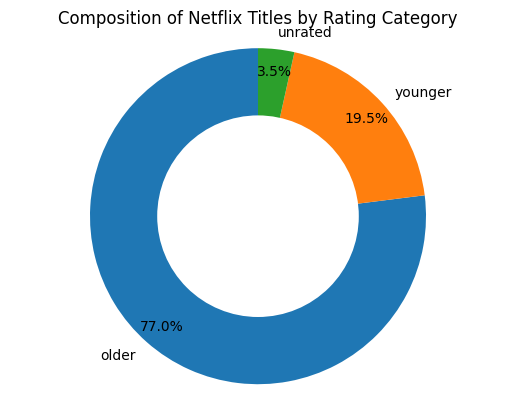

In [ ]:


import matplotlib.pyplot as plt

# Assuming 'df' and 'rating' column are defined as in the previous code

rating_percent = df['rating'].value_counts(normalize=True) * 100

labels = rating_percent.index
sizes = rating_percent.values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.87)

centre_circle = plt.Circle((0, 0), 0.6, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax.axis('equal')

plt.title('Composition of Netflix Titles by Rating Category')
plt.show()


In [ ]:
#  find the min and max values for "date_added"
min_date = df['date_added'].min()
max_date = df['date_added'].max()

print(f"Minimum date_added: {min_date}")
print(f"Maximum date_added: {max_date}")


min_release_year = df['release_year'].min()
max_release_year = df['release_year'].max()

print(f"Minimum release year: {min_release_year}")
print(f"Maximum release year: {max_release_year}")


Minimum date_added: 2008-01-01 00:00:00
Maximum date_added: 2021-09-25 00:00:00
Minimum release year: 1942
Maximum release year: 2021


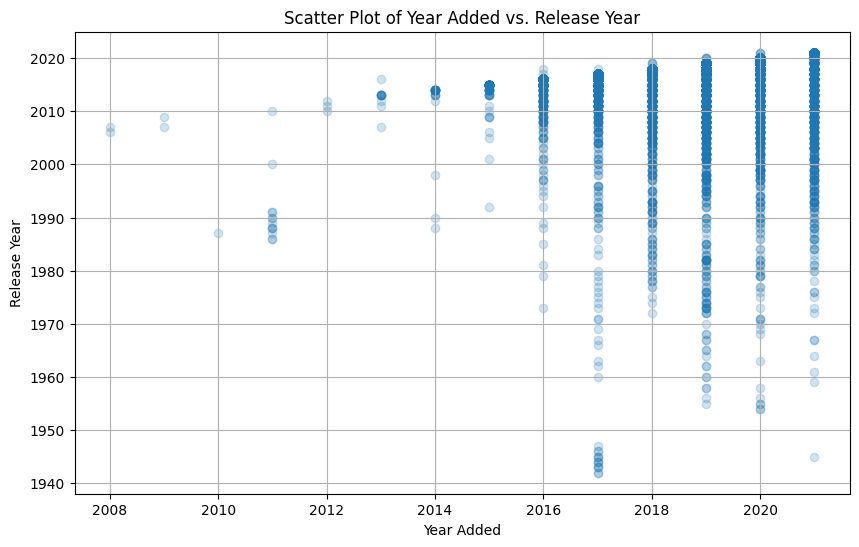

In [ ]:
# prompt: generate a scatter plot of year added and release year with an alpha of 0.5

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df['year_added'], df['release_year'], alpha=0.2)
plt.xlabel('Year Added')
plt.ylabel('Release Year')
plt.title('Scatter Plot of Year Added vs. Release Year')
plt.grid(True)
plt.show()


In [ ]:
# Create the pivot table
total= df.shape[0]

pivot_table = pd.pivot_table(df, values='show_id', index='rating', columns='type', aggfunc='count', fill_value=0)

# Calculate the percentage values
percentage_table = (pivot_table / total) * 100

# Round the percentage values
rounded_table = percentage_table.round(2)

# Display the rounded table
print("Percent Composition by Age Group and Type")
display(rounded_table)

Percent Composition by Age Group and Type


type     Movie  TV Show
rating                 
older    56.56    20.42
unrated   2.40     1.08
younger  12.47     7.06

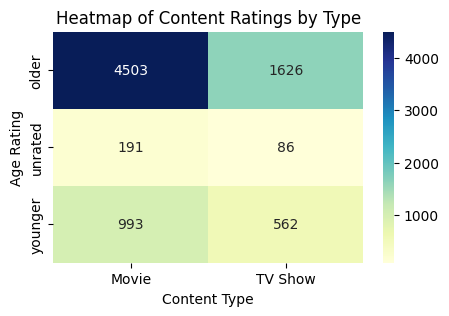

In [ ]:

plt.figure(figsize=(5, 3))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of Content Ratings by Type")
plt.xlabel("Content Type")
plt.ylabel("Age Rating")
plt.show()


## Analyzing count of movies vs TV shows

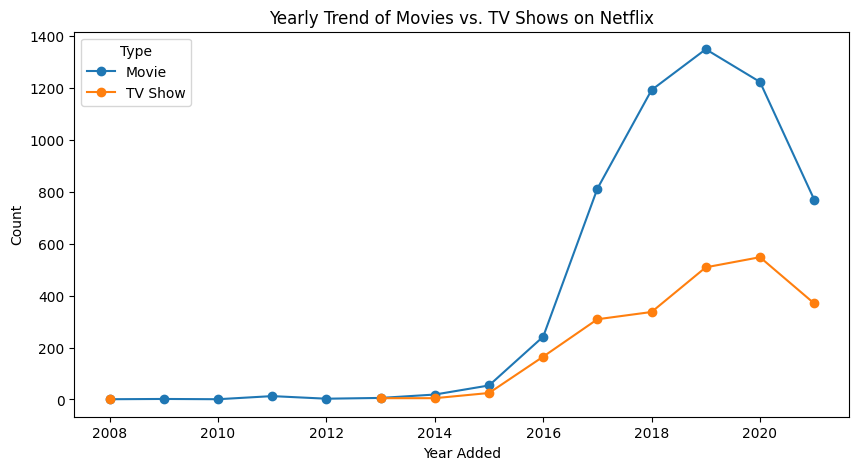

In [ ]:
df['year_added'] = df['date_added'].dt.year  # Extract year from date_added

yearly_trend = df.groupby(['year_added', 'type']).size().unstack()
yearly_trend.plot(kind='line', marker='o', figsize=(10,5))
plt.xlabel("Year Added")
plt.ylabel("Count")
plt.title("Yearly Trend of Movies vs. TV Shows on Netflix")
plt.legend(title="Type")
plt.show()

#Get counts for top genres by TV shows and Movies

In [ ]:
from itertools import combinations
from collections import Counter

# Extract genre combinations from the 'listed_in' column, which already contains lists of genres
genre_combinations = df['listed_in'].dropna().apply(lambda x: list(combinations(x, 2)))

# Count the frequency of each genre combination
genre_counts = Counter([pair for sublist in genre_combinations for pair in sublist])

# Print the most common genre combinations
genre_counts.most_common(10)

[(('Dramas', 'International Movies'), 1383),
 (('Comedies', 'International Movies'), 753),
 (('Dramas', 'Independent Movies'), 578),
 (('Comedies', 'Dramas'), 484),
 (('International TV Shows', 'TV Dramas'), 421),
 (('Action & Adventure', 'International Movies'), 365),
 (('International Movies', 'Romantic Movies'), 349),
 (('Dramas', 'Romantic Movies'), 291),
 (('Independent Movies', 'International Movies'), 283),
 (('Comedies', 'Romantic Movies'), 266)]

In [ ]:
movie_generes = df[df['type'] == 'Movie']['listed_in'].explode().value_counts().head(10)
tv_generes = df[df['type'] == 'TV Show']['listed_in'].explode().value_counts().head(10)
all_generes = df['listed_in'].explode().value_counts().head(10)

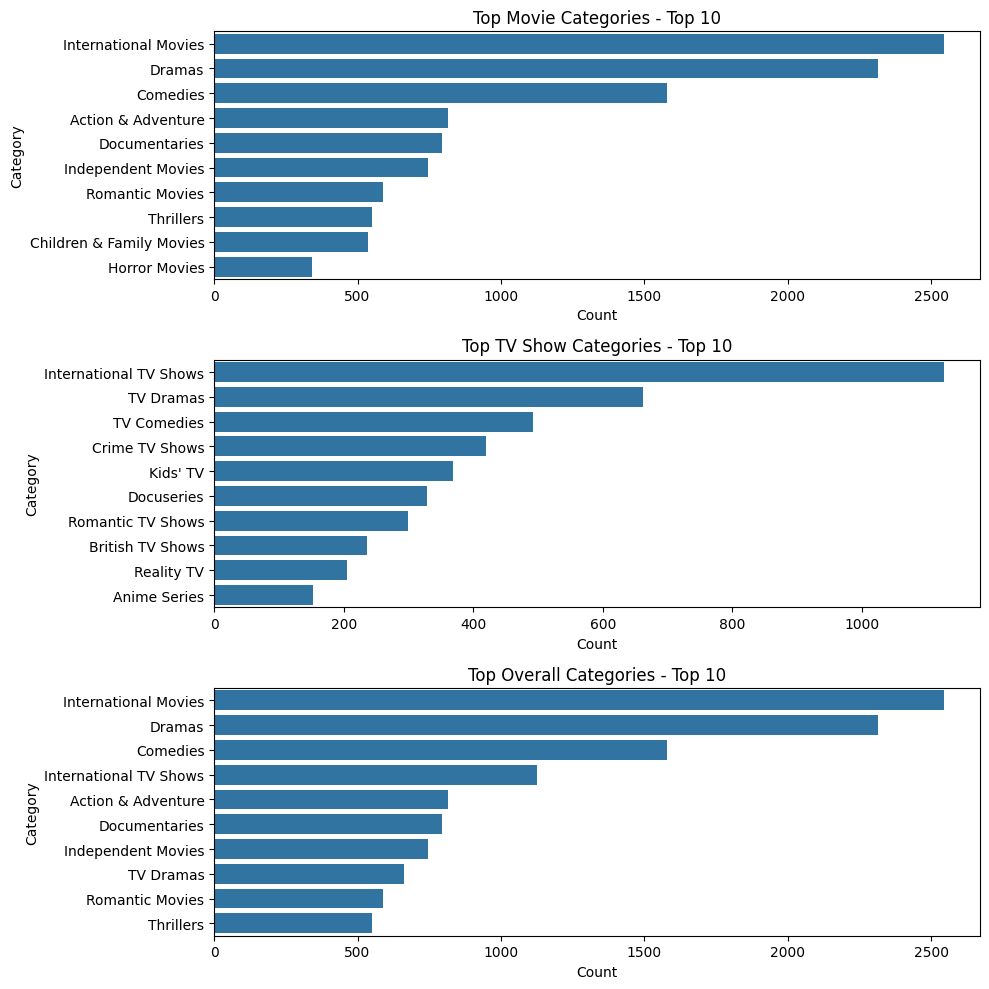

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Plot Top Movie Categories
sns.barplot(x=movie_generes.values, y=movie_generes.index, ax=axes[0])
axes[0].set_title("Top Movie Categories - Top 10")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Category")

# Plot Top TV Show Categories
sns.barplot(x=tv_generes.values, y=tv_generes.index, ax=axes[1])
axes[1].set_title("Top TV Show Categories - Top 10")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Category")

# Plot Top Overall Categories
sns.barplot(x=all_generes.values, y=all_generes.index, ax=axes[2])
axes[2].set_title("Top Overall Categories - Top 10")
axes[2].set_xlabel("Count")
axes[2].set_ylabel("Category")

# Improve layout
plt.tight_layout()
plt.show()

## Ratings

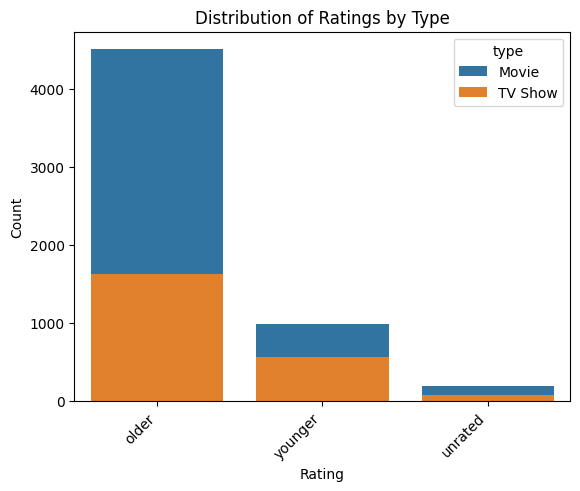

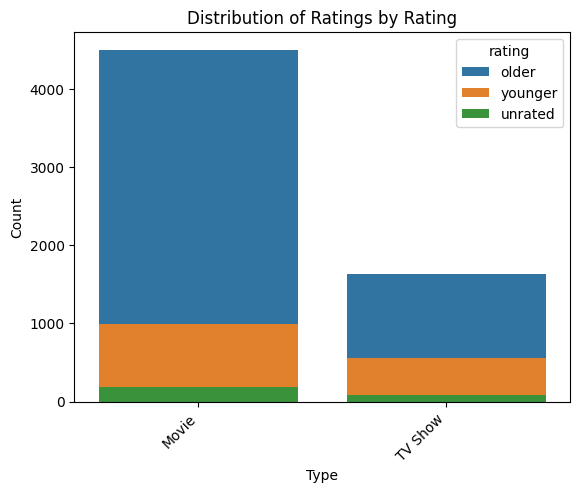

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.countplot(data=df, x='rating', hue='type', dodge=False, order=df['rating'].value_counts().index)

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings by Type")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


sns.countplot(data=df, x='type', hue='rating', dodge=False, order=df['type'].value_counts().index)

plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Distribution of Ratings by Rating")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

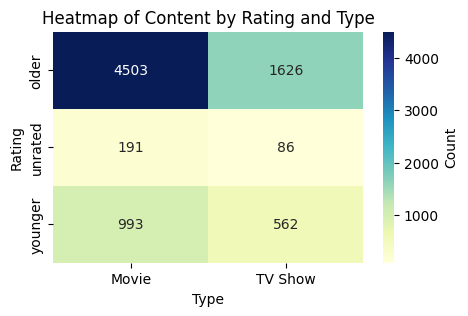

In [ ]:
# heatmap of the above cell with rating down the side and type at the top

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'pivot_table' from the previous code is available
plt.figure(figsize=(5, 3))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.xlabel("Type")
plt.ylabel("Rating")
plt.title("Heatmap of Content by Rating and Type")
plt.show()


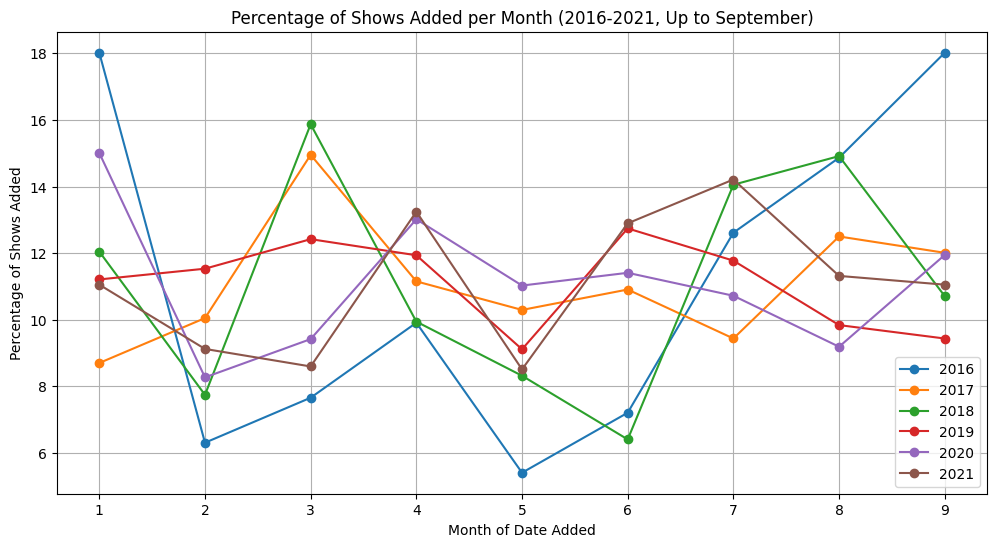

In [ ]:

# Extract month and year from the 'date_added' column
df['month_added'] = df['date_added'].dt.month  # Creating the 'month_added' column
df['year_added'] = df['date_added'].dt.year  # Creating the 'year_added' column


# Filter data for years 2016 and later and months up to September
df_filtered = df[(df['year_added'] >= 2016) & (df['month_added'] <= 9)]

# Group by year and month, then count the show IDs
monthly_counts = df_filtered.groupby(['year_added', 'month_added'])['show_id'].count().reset_index()

# Calculate the total count for each year
yearly_totals = monthly_counts.groupby('year_added')['show_id'].sum()

# Calculate the percentage for each month within each year
monthly_percentages = []
for year, group in monthly_counts.groupby('year_added'):
  group['percentage'] = (group['show_id'] / yearly_totals[year]) * 100
  monthly_percentages.append(group)

# Concatenate the results back into a single DataFrame
monthly_percentages_df = pd.concat(monthly_percentages)

# Create the line chart
plt.figure(figsize=(12, 6))
for year, group in monthly_percentages_df.groupby('year_added'):
    plt.plot(group['month_added'], group['percentage'], label=str(year), marker='o')

plt.xlabel('Month of Date Added')
plt.ylabel('Percentage of Shows Added')
plt.title('Percentage of Shows Added per Month (2016-2021, Up to September)') # Updated title
plt.xticks(range(1, 10))  # Set x-axis ticks up to September (9)
plt.legend()
plt.grid(True)
plt.show()

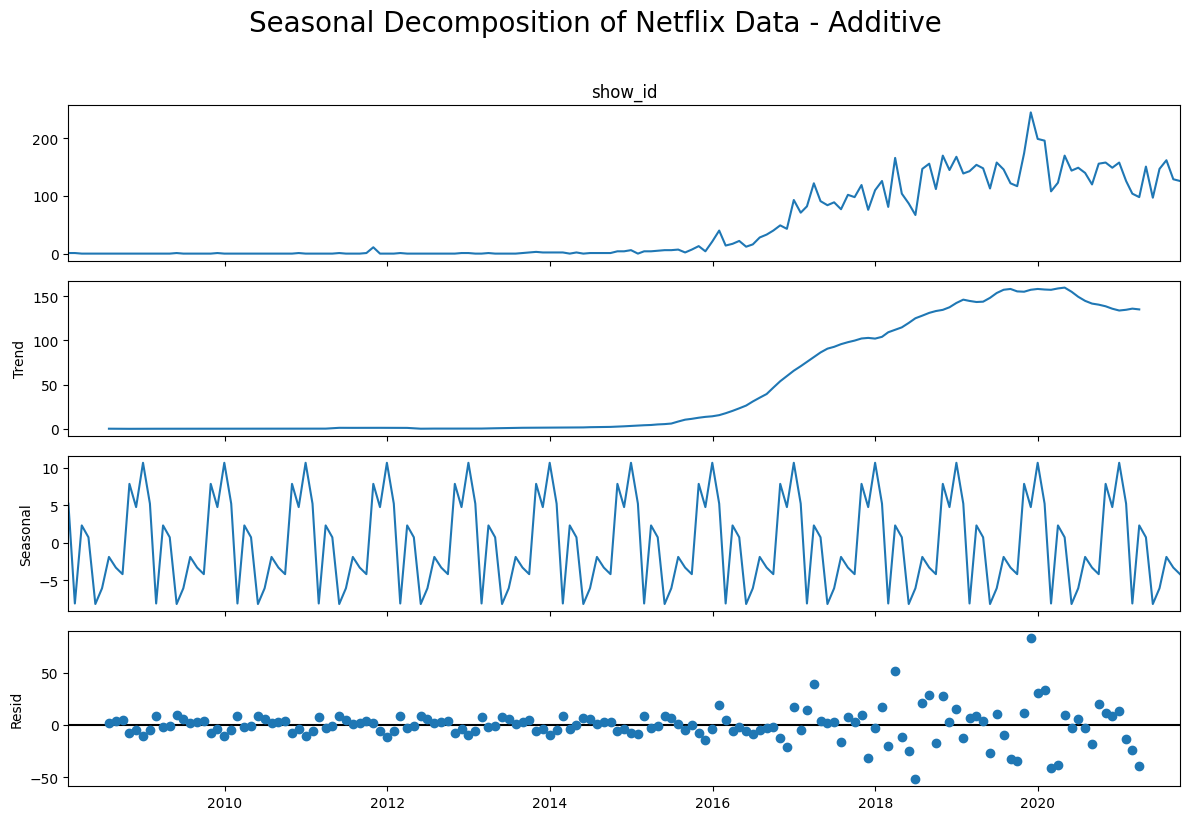

date_added
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
              ..
2021-05-31   NaN
2021-06-30   NaN
2021-07-31   NaN
2021-08-31   NaN
2021-09-30   NaN
Freq: ME, Name: trend, Length: 165, dtype: float64

date_added
2008-01-31    5.231904
2008-02-29   -8.085403
2008-03-31    2.328058
2008-04-30    0.744191
2008-05-31   -8.155115
                ...   
2021-05-31   -8.155115
2021-06-30   -6.054420
2021-07-31   -1.873865
2021-08-31   -3.296942
2021-09-30   -4.171942
Freq: ME, Name: seasonal, Length: 165, dtype: float64

date_added
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
              ..
2021-05-31   NaN
2021-06-30   NaN
2021-07-31   NaN
2021-08-31   NaN
2021-09-30   NaN
Freq: ME, Name: resid, Length: 165, dtype: float64

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure 'date_added' is the index for time series decomposition
df_decompose = df.set_index('date_added')

# Resample the data to a monthly frequency and count the number of entries
monthly_data = df_decompose['show_id'].resample('M').count()

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_data, model='additive', period=12)  # Fixed typo from 'addative'

# Plot the decomposition components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Seasonal Decomposition of Netflix Data - Additive', fontsize=20, y=1.02)  # Move title above subplots

plt.tight_layout()
plt.show()

display(decomposition.trend)
display(decomposition.seasonal)
display(decomposition.resid)


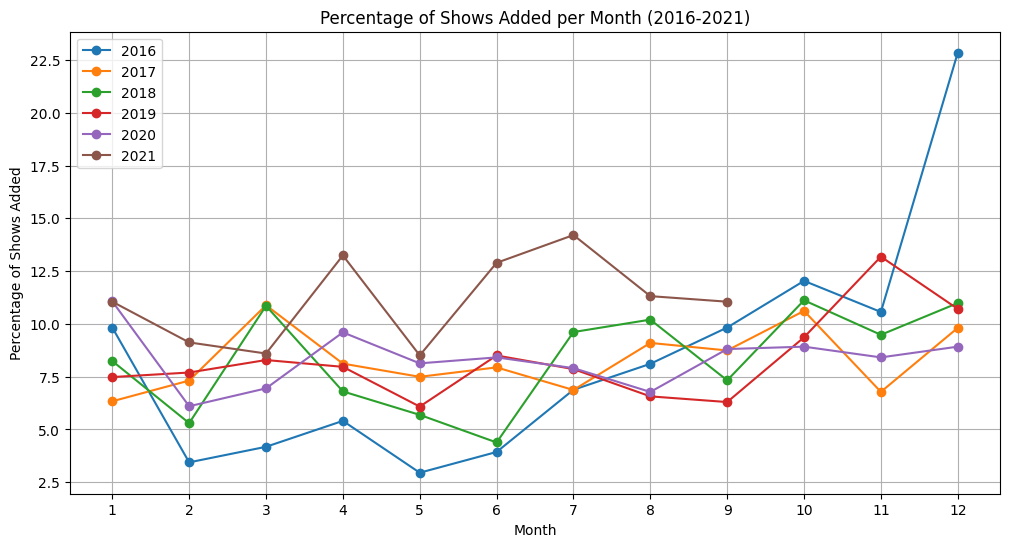

In [ ]:

# Filter data for years 2016 and later
df_filtered = df[df['year_added'] >= 2016]

# Group by year and month, then count the show IDs
monthly_counts = df_filtered.groupby(['year_added', 'month_added'])['show_id'].count().reset_index()

# Calculate the total count for each year
yearly_totals = monthly_counts.groupby('year_added')['show_id'].sum()

# Calculate the percentage for each month within each year
monthly_percentages = []
for year, group in monthly_counts.groupby('year_added'):
  group['percentage'] = (group['show_id'] / yearly_totals[year]) * 100
  monthly_percentages.append(group)

# Concatenate the results back into a single DataFrame
monthly_percentages_df = pd.concat(monthly_percentages)

# Create the line chart
plt.figure(figsize=(12, 6))
for year, group in monthly_percentages_df.groupby('year_added'):
    plt.plot(group['month_added'], group['percentage'], label=str(year), marker='o')

plt.xlabel('Month')
plt.ylabel('Percentage of Shows Added')
plt.title('Percentage of Shows Added per Month (2016-2021)')
plt.xticks(range(1, 13))  # Set x-axis ticks for each month
plt.legend()
plt.grid(True)
plt.show()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


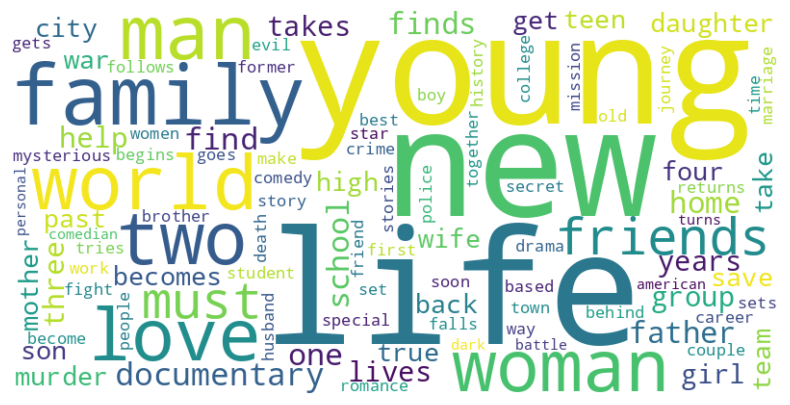

life: 715
young: 672
new: 639
family: 572
man: 475
world: 473
two: 449
love: 443
woman: 438
friends: 370
must: 355
documentary: 337
one: 322
find: 315
school: 306
finds: 293
father: 285
home: 281
three: 262
help: 261
lives: 248
takes: 240
group: 237
years: 236
girl: 223
take: 211
back: 210
teen: 205
high: 199
daughter: 198
son: 193
save: 192
city: 190
mother: 190
becomes: 188
get: 188
true: 184
team: 184
murder: 181
war: 176
wife: 176
four: 175
past: 173
mysterious: 171
friend: 169
death: 168
special: 168
story: 167
gets: 164
comedy: 164
town: 156
best: 156
boy: 156
tries: 152
soon: 151
women: 151
secret: 151
crime: 150
way: 149
follows: 148
falls: 148
student: 146
time: 144
couple: 142
become: 142
make: 141
behind: 138
former: 136
together: 136
returns: 135
police: 134
fight: 132
first: 128
begins: 128
based: 127
star: 125
brother: 124
old: 124
mission: 123
work: 122
drama: 122
romance: 122
journey: 122
stories: 122
evil: 121
college: 120
marriage: 118
history: 118
set: 118
people: 11

In [ ]:


!pip install nltk
import nltk
nltk.download('punkt_tab') # Download 'punkt' to resolve the error
nltk.download('punkt') # Download 'punkt' to resolve the error
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update(["movie", "film", "series", "show"]) # Add custom stopwords


def word_frequency(description_column):
    # Tokenize the text and convert to lowercase
    tokens = []
    for text in description_column:
      if isinstance(text, str): #handle missing values
          tokens.extend(word_tokenize(text.lower()))

    # Remove stop words and punctuation
    filtered_tokens = [w for w in tokens if not w in stop_words and w.isalnum()]

    # Count word frequencies
    word_counts = Counter(filtered_tokens)

    # Get the top 100 most frequent words
    top_100_words = word_counts.most_common(100)

    return top_100_words

# Call the function with your description column
top_words = word_frequency(df['description'])


# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Print top 100 words with frequencies
for word, count in top_words:
  print(f"{word}: {count}")

#Duration Charts

In [ ]:
#Create Data Frames for Movies and Data Frame for TV shows

# DataFrame for Movies
movie_df = df[df['type'] == 'Movie']
movie_duration_counts = movie_df.groupby(['year_added', 'duration']).size().reset_index(name='count')

# DataFrame for TV Shows
tv_show_df = df[df['type'] == 'TV Show']
tv_show_duration_counts = tv_show_df.groupby(['year_added', 'duration']).size().reset_index(name='count')

# Display the DataFrames
print("Movie Duration Counts:")
display(movie_duration_counts)

print("\nTV Show Duration Counts:")
display(tv_show_duration_counts)

Movie Duration Counts:


year_added duration  count
0          2008   81 min      1
1          2009  104 min      1
2          2009   29 min      1
3          2010   84 min      1
4          2011  103 min      1
..          ...      ...    ...
868        2021   95 min     22
869        2021   96 min     16
870        2021   97 min     31
871        2021   98 min     22
872        2021   99 min     18

[873 rows x 3 columns]


TV Show Duration Counts:


year_added   duration  count
0         2008   1 Season      1
1         2013   1 Season      2
2         2013  4 Seasons      1
3         2013  5 Seasons      1
4         2013  6 Seasons      1
..         ...        ...    ...
71        2021  5 Seasons     15
72        2021  6 Seasons     10
73        2021  7 Seasons      6
74        2021  8 Seasons      1
75        2021  9 Seasons      2

[76 rows x 3 columns]

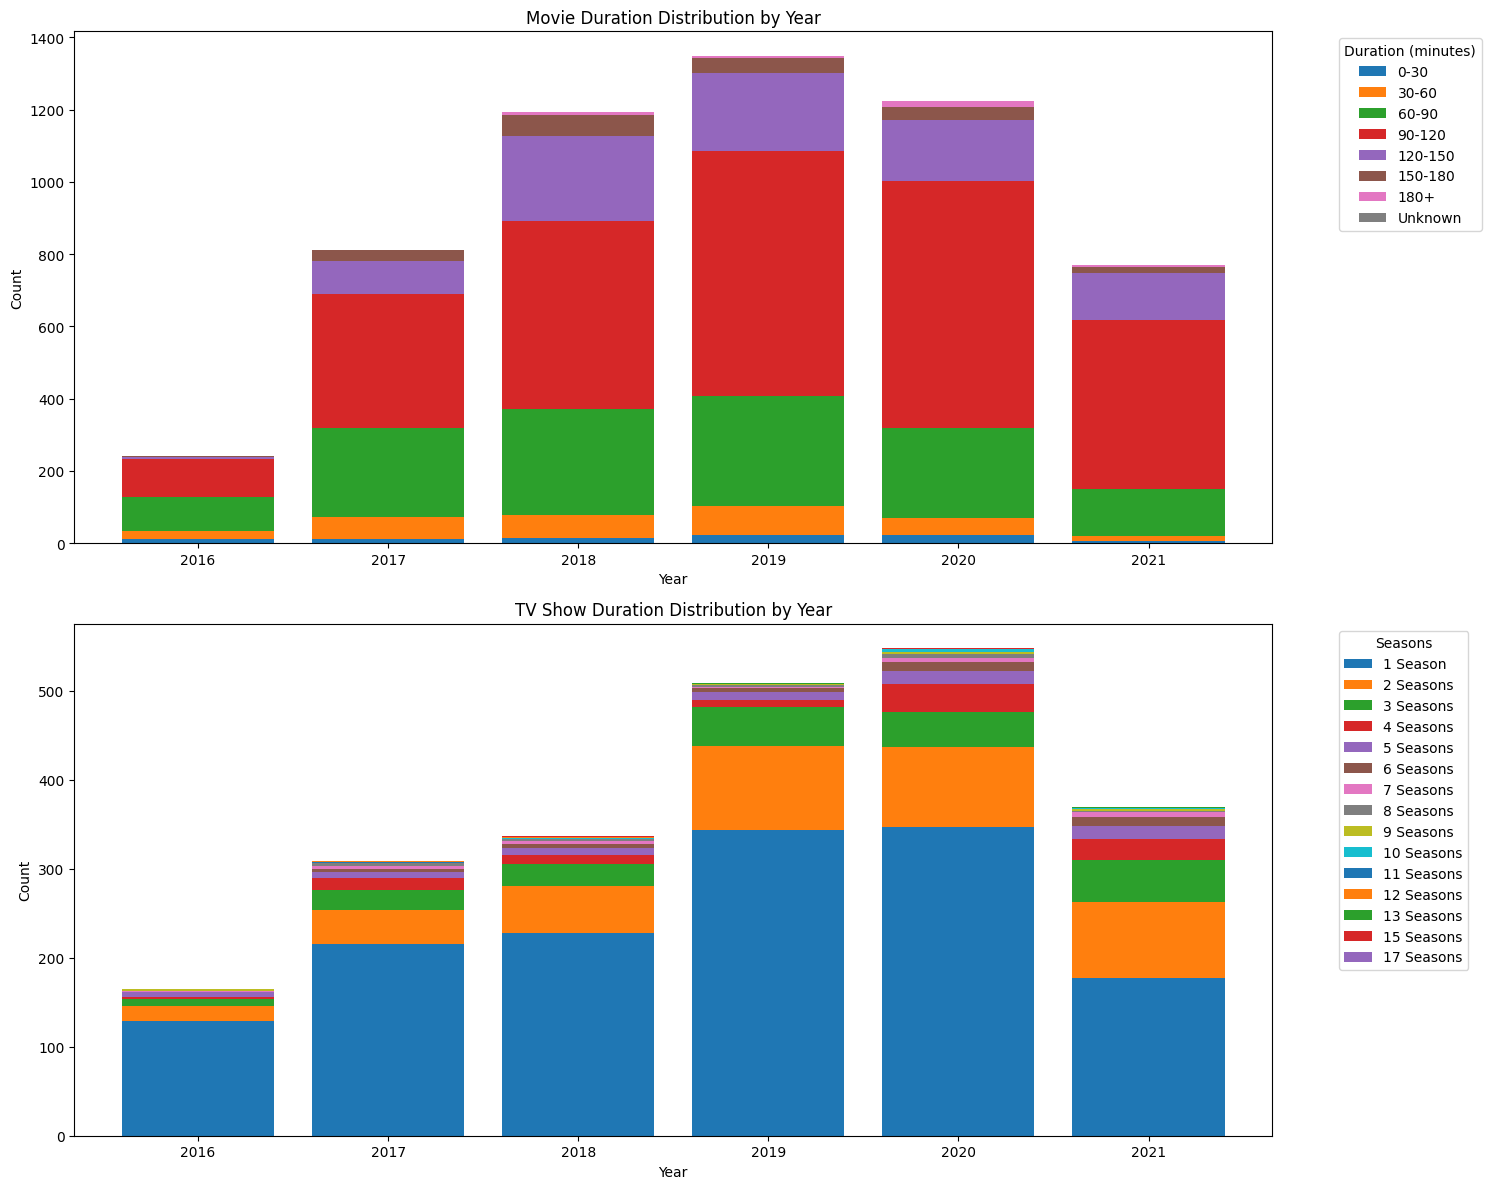

In [ ]:
import matplotlib.pyplot as plt

# Filter data for years 2016 and onwards
df_filtered = df[df['year_added'] >= 2016]
movie_df_filtered = movie_df[movie_df['year_added'] >= 2016]
tv_show_df_filtered = tv_show_df[tv_show_df['year_added'] >= 2016]

# Function to create duration bins for movies
def categorize_duration(duration):
    if isinstance(duration, str):
        try:
            duration_num = int(duration.split()[0])
            if duration_num <= 30:
                return '0-30'
            elif duration_num <= 60:
                return '30-60'
            elif duration_num <= 90:
                return '60-90'
            elif duration_num <= 120:
                return '90-120'
            elif duration_num <= 150:
                return '120-150'
            elif duration_num <= 180:
                return '150-180'
            else:
                return '180+'
        except (ValueError, IndexError, AttributeError):
            return 'Unknown'
    else:
        return 'Unknown'

# Apply categorization to movie durations
movie_df_filtered['duration_category'] = movie_df_filtered['duration'].apply(categorize_duration)

# Group movie data by year and duration category
movie_duration_grouped = movie_df_filtered.groupby(['year_added', 'duration_category']).size().unstack(fill_value=0)

# Define and apply desired movie duration order
duration_order = ['0-30', '30-60', '60-90', '90-120', '120-150', '150-180', '180+', 'Unknown']
movie_duration_grouped = movie_duration_grouped.reindex(columns=duration_order, fill_value=0)

# Group TV show data by year and duration string
tv_show_duration_grouped = tv_show_df_filtered.groupby(['year_added', 'duration']).size().unstack(fill_value=0)

# Function to extract season number from duration string
def extract_season_number(duration_str):
    try:
        return int(duration_str.split()[0])
    except:
        return float('inf')  # For 'Unknown' or malformed strings

# Sort TV show durations numerically
sorted_tv_columns = sorted(tv_show_duration_grouped.columns, key=extract_season_number)
tv_show_duration_grouped = tv_show_duration_grouped[sorted_tv_columns]

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Movie Chart
movie_duration_grouped.plot(kind='bar', stacked=True, ax=axes[0], width=0.8)
axes[0].set_title('Movie Duration Distribution by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')
axes[0].legend(title='Duration (minutes)', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=0)

# TV Show Chart
tv_show_duration_grouped.plot(kind='bar', stacked=True, ax=axes[1], width=0.8)
axes[1].set_title('TV Show Duration Distribution by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')
axes[1].legend(title='Seasons', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()



In [ ]:

# Function to create duration bins for movies
def categorize_movie_duration(duration):
    if isinstance(duration, str):
        try:
            duration_num = int(duration.split()[0])
            if duration_num <= 30:
                return '0-30'
            elif duration_num <= 60:
                return '30-60'
            elif duration_num <= 90:
                return '60-90'
            elif duration_num <= 120:
                return '90-120'
            elif duration_num <= 150:
                return '120-150'
            elif duration_num <= 180:
                return '150-180'
            else:
                return '180+'
        except (ValueError, IndexError, AttributeError):
            return 'Unknown'
    else:
        return 'Unknown'

# Function to extract season number for TV shows
def extract_tv_season(duration):
    try:
        return int(duration.split()[0])
    except:
        return float('inf')  # Unknown or malformed

# Filter data for years 2016 and onwards
df_filtered = df[df['year_added'] >= 2016]
movie_df_filtered = df_filtered[df_filtered['type'] == 'Movie']
tv_show_df_filtered = df_filtered[df_filtered['type'] == 'TV Show']

# Apply categorization
movie_df_filtered['duration_category'] = movie_df_filtered['duration'].apply(categorize_movie_duration)
tv_show_df_filtered['duration_category'] = tv_show_df_filtered['duration']  # Use raw duration (e.g., "2 Seasons")

# Group and pivot
movie_duration_grouped = movie_df_filtered.groupby(['year_added', 'duration_category']).size().unstack(fill_value=0)
tv_show_duration_grouped = tv_show_df_filtered.groupby(['year_added', 'duration_category']).size().unstack(fill_value=0)

# Sort movie columns by defined duration range order
movie_duration_order = ['0-30', '30-60', '60-90', '90-120', '120-150', '150-180', '180+', 'Unknown']
movie_duration_grouped = movie_duration_grouped.reindex(columns=movie_duration_order, fill_value=0)

# Sort TV columns numerically based on number of seasons
tv_ordered_cols = sorted(tv_show_duration_grouped.columns, key=lambda x: extract_tv_season(x))
tv_show_duration_grouped = tv_show_duration_grouped[tv_ordered_cols]

# Show the result
print("\nMovie Duration Counts (2016 onwards):")
display(movie_duration_grouped)

print("\nTV Show Duration Counts (2016 onwards):")
display(tv_show_duration_grouped)




Movie Duration Counts (2016 onwards):


duration_category  0-30  30-60  60-90  90-120  120-150  150-180  180+  Unknown
year_added                                                                    
2016                 13     22     93     106        5        3     0        0
2017                 11     62    247     369       91       32     0        0
2018                 15     62    294     520      237       56     8        0
2019                 24     78    305     678      217       41     6        0
2020                 24     47    248     682      169       37    16        0
2021                  6     15    128     470      130       15     6        0


TV Show Duration Counts (2016 onwards):


duration_category  1 Season  2 Seasons  3 Seasons  4 Seasons  5 Seasons  \
year_added                                                                
2016                    129         17          8          2          6   
2017                    215         39         22         14          7   
2018                    228         53         24         10          8   
2019                    344         94         44          8          9   
2020                    347         90         39         32         14   
2021                    177         86         47         23         15   

duration_category  6 Seasons  7 Seasons  8 Seasons  9 Seasons  10 Seasons  \
year_added                                                                  
2016                       0          1          0          2           0   
2017                       3          3          4          0           0   
2018                       5          3          3          0           1   
2019                       4          1          3          1           0   
2020                      10          5          4          3           3   
2021                      10          6          1          2           1   

duration_category  11 Seasons  12 Seasons  13 Seasons  15 Seasons  17 Seasons  
year_added                                                                     
2016                        0           0           0           0           0  
2017                        1           1           0           0           0  
2018                        0           1           0           1           0  
2019                        0           0           1           0           0  
2020                        0           0           0           1           0  
2021                        0           0           1           0           1

#New Titles vs Old Titles

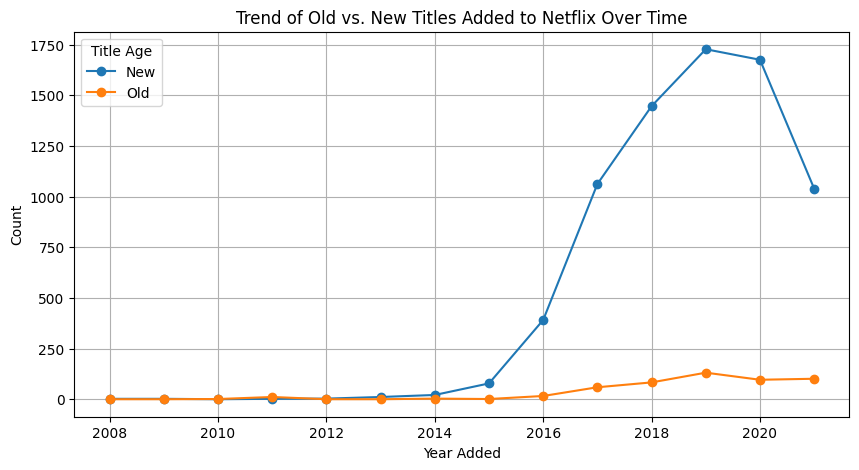

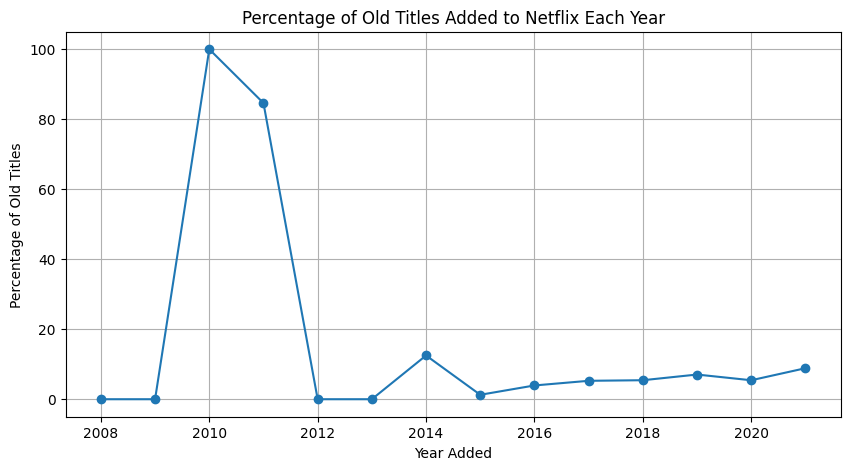

In [ ]:
# prompt: I want to see if they are purchasing more old titles as the years go by or not.

# Assuming 'df' is your DataFrame and 'release_year' is the column containing the release year of the shows.

import matplotlib.pyplot as plt

# Define a threshold year to distinguish between "old" and "new" titles.
threshold_year = 2000  # You can adjust this threshold

# Create a new column to categorize titles as "old" or "new"
df['title_age'] = df['release_year'].apply(lambda year: 'Old' if year < threshold_year else 'New')

# Group the data by year added and title age
title_age_trend = df.groupby(['year_added', 'title_age']).size().unstack(fill_value=0)

# Plot the trend
title_age_trend.plot(kind='line', marker='o', figsize=(10, 5))
plt.xlabel('Year Added')
plt.ylabel('Count')
plt.title('Trend of Old vs. New Titles Added to Netflix Over Time')
plt.legend(title='Title Age')
plt.grid(True)
plt.show()

# Calculate the percentage of old titles added each year
title_age_trend['Old_Percentage'] = (title_age_trend['Old'] / (title_age_trend['Old'] + title_age_trend['New'])) * 100

# Plot the percentage of old titles
plt.figure(figsize=(10, 5))
plt.plot(title_age_trend.index, title_age_trend['Old_Percentage'], marker='o')
plt.xlabel('Year Added')
plt.ylabel('Percentage of Old Titles')
plt.title('Percentage of Old Titles Added to Netflix Each Year')
plt.grid(True)
plt.show()


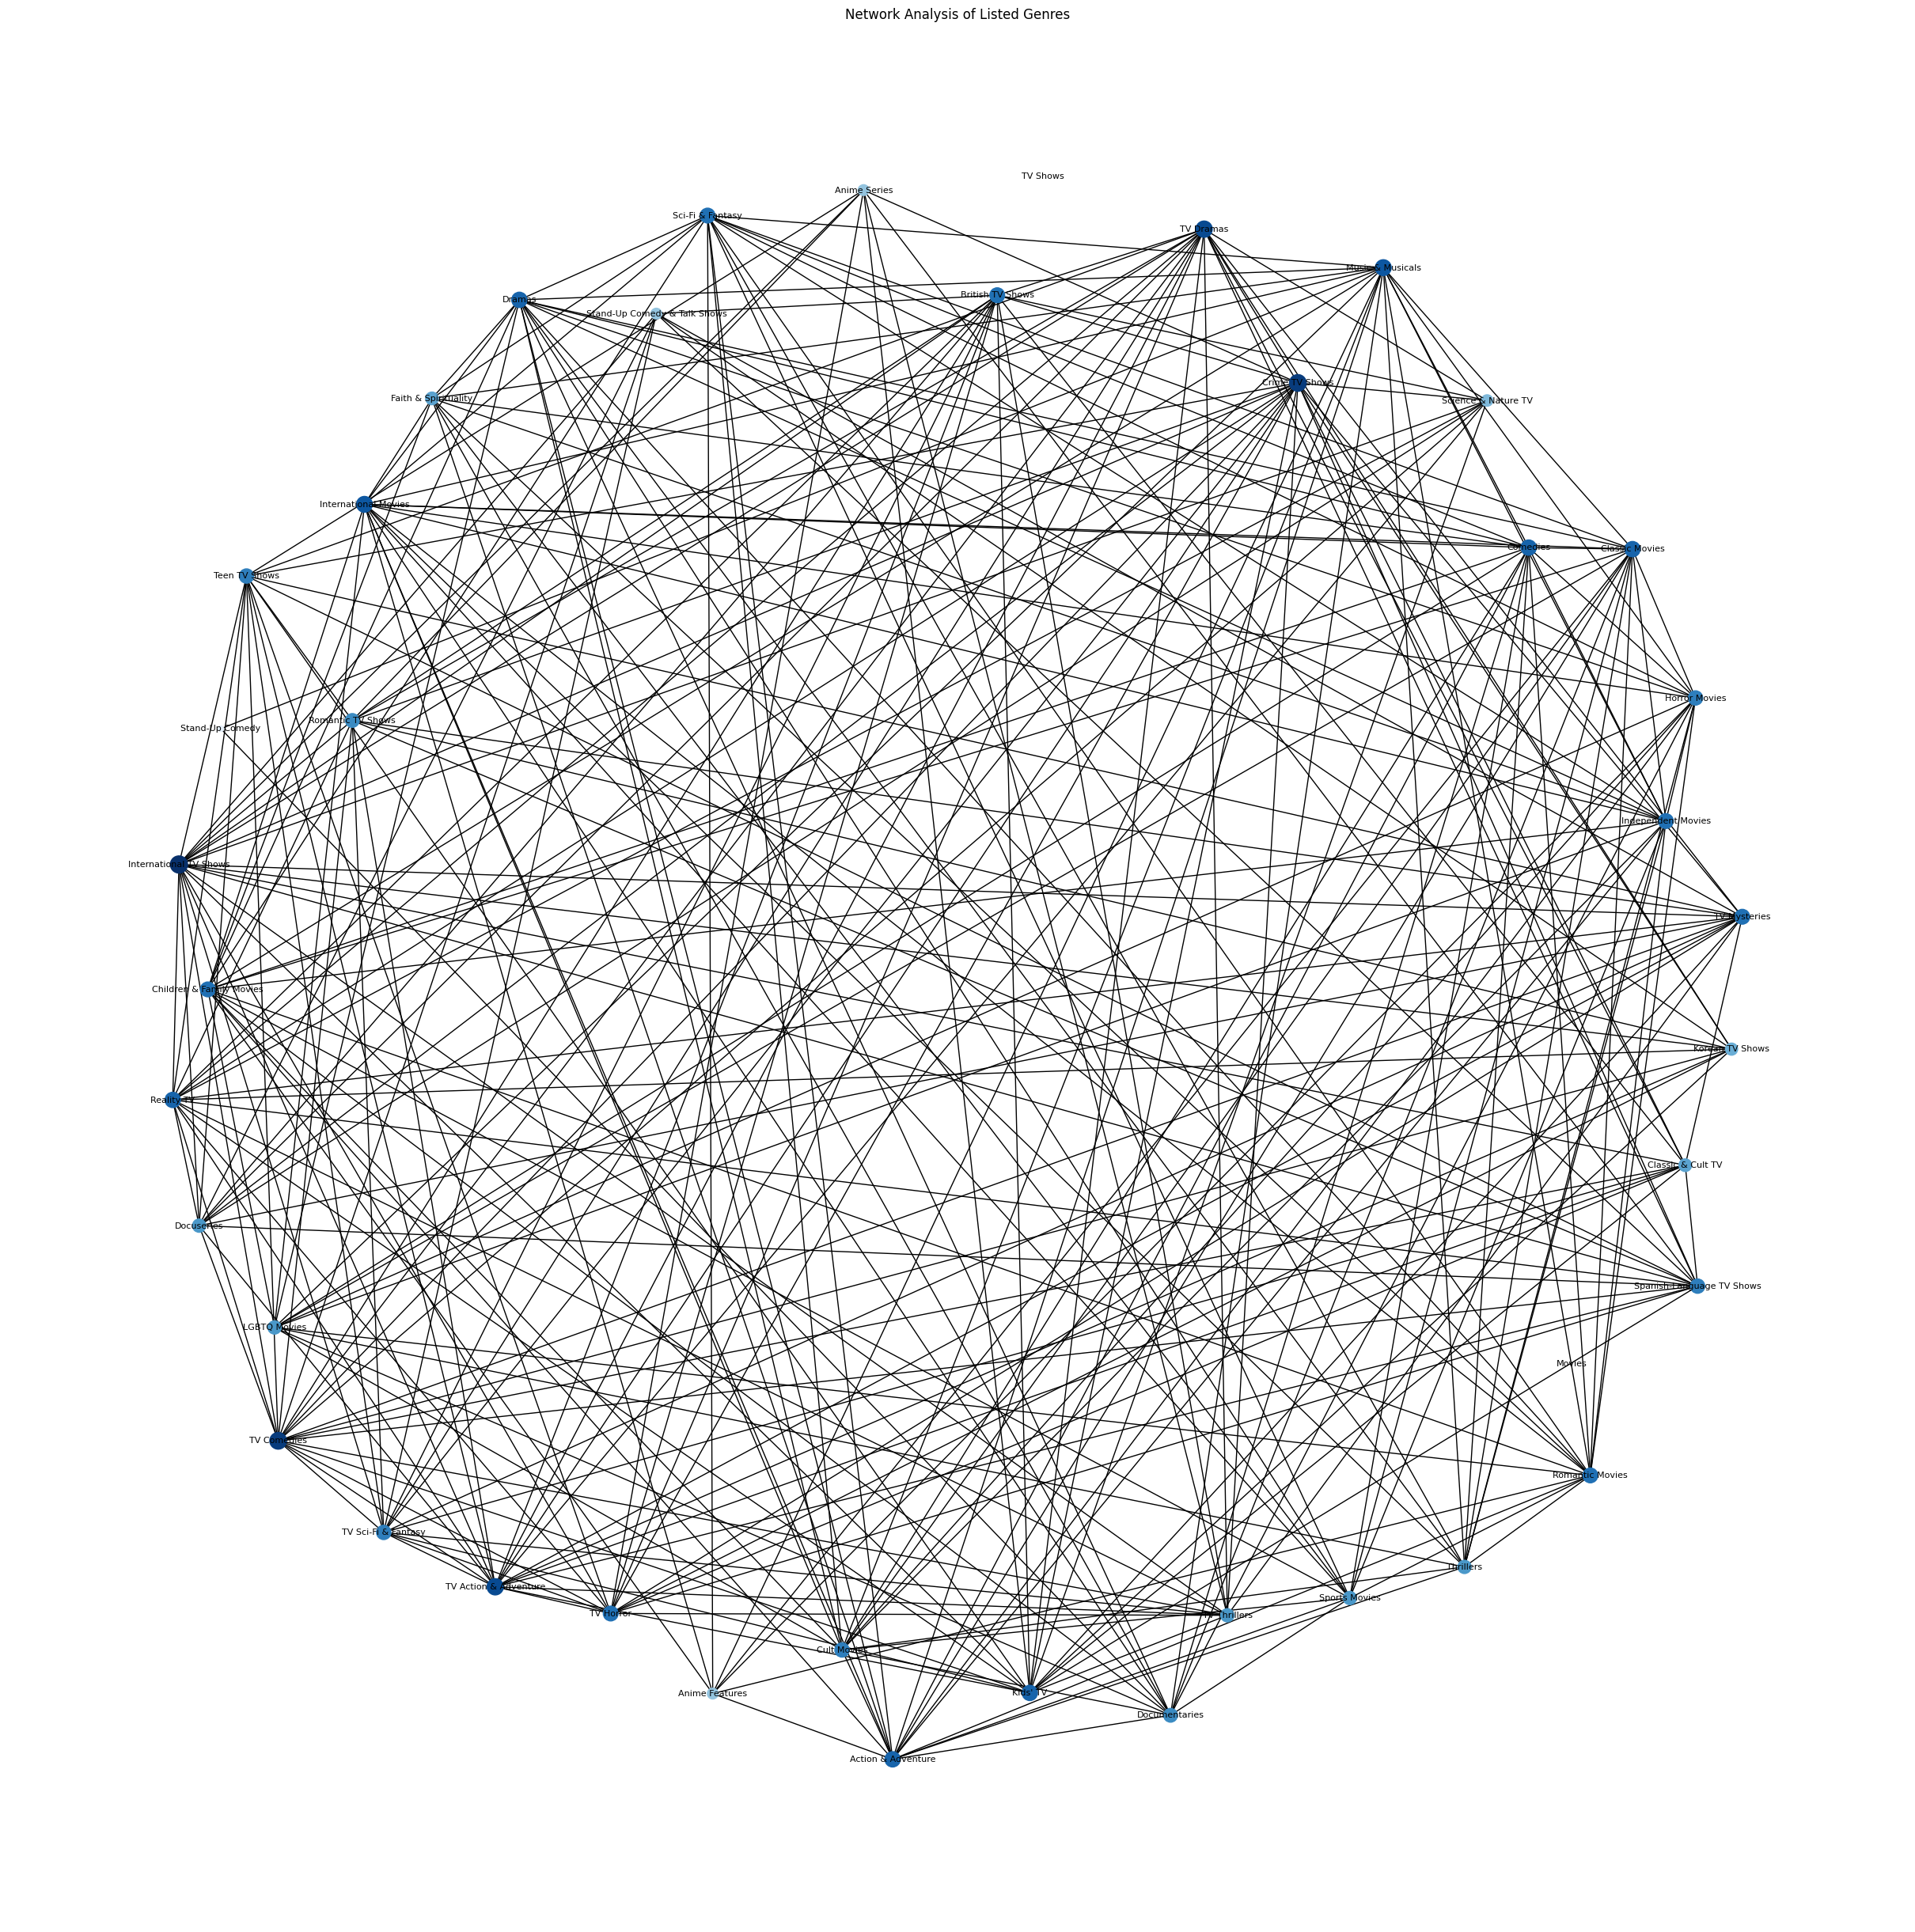

In [ ]:
## Don't use, hard to understand


import networkx as nx
import matplotlib.pyplot as plt

# Assuming df_exploded is the DataFrame with exploded 'listed_in' column

# Create a list of unique genres
unique_genres = df_exploded['listed_in'].unique().tolist()

# Create an empty graph
genre_graph = nx.Graph()

# Add nodes to the graph for each genre
genre_graph.add_nodes_from(unique_genres)

# Create edges based on co-occurrence in the same 'show_id'
for show_id, group in df_exploded.groupby('show_id'):
    genres_for_show = group['listed_in'].tolist()
    for genre1, genre2 in combinations(genres_for_show, 2):
        if genre_graph.has_edge(genre1, genre2):
          genre_graph[genre1][genre2]['weight'] +=1
        else:
          genre_graph.add_edge(genre1, genre2, weight=0.5)

# Calculate degree centrality to find important genres
degree_centrality = nx.degree_centrality(genre_graph)


# Draw the network
plt.figure(figsize=(24, 24))
pos = nx.spring_layout(genre_graph, k=1000)  # Adjust k for node spacing
nx.draw(genre_graph, pos, with_labels=True, node_size=[v * 500 for v in degree_centrality.values()],
        node_color=[v for v in degree_centrality.values()], cmap=plt.cm.Blues, font_size=8)

# Add edge labels (optional)
#edge_labels = nx.get_edge_attributes(genre_graph, 'weight')
#nx.draw_networkx_edge_labels(genre_graph, pos, edge_labels=edge_labels, font_size=6)


plt.title("Network Analysis of Listed Genres")
plt.show()


In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

def create_genre_matrix(df):
    # Split genres, strip whitespace, and sort alphabetically
    df2 = df.copy()
    df2['listed_in'] = df['listed_in'].apply(lambda x: sorted(x))
    print(df2['listed_in'])

    # Join sorted genres with a delimiter and convert to dummy variables
    genre_matrix = df2['listed_in'].str.join('|').str.get_dummies()

    return genre_matrix

# Create the genre matrix
genre_matrix = create_genre_matrix(df)

# Apply the Apriori algorithm
frequent_itemsets = apriori(genre_matrix, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort the rules by support in descending order
rules_sorted = rules.sort_values(by='support', ascending=False)

# Display the sorted rules
rules_sorted


0                                         [Documentaries]
1       [International TV Shows, TV Dramas, TV Mysteries]
4       [International TV Shows, Romantic TV Shows, TV...
7       [Dramas, Independent Movies, International Mov...
8                          [British TV Shows, Reality TV]
                              ...                        
8801            [Dramas, International Movies, Thrillers]
8802                     [Cult Movies, Dramas, Thrillers]
8804                            [Comedies, Horror Movies]
8805                 [Children & Family Movies, Comedies]
8806     [Dramas, International Movies, Music & Musicals]
Name: listed_in, Length: 7961, dtype: object


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


antecedents               consequents  antecedent support  \
6                  (Dramas)    (International Movies)            0.290918   
7    (International Movies)                  (Dramas)            0.319432   
2                (Comedies)    (International Movies)            0.198468   
3    (International Movies)                (Comedies)            0.319432   
5      (Independent Movies)                  (Dramas)            0.093581   
4                  (Dramas)      (Independent Movies)            0.290918   
1                (Comedies)                  (Dramas)            0.198468   
0                  (Dramas)                (Comedies)            0.290918   
8  (International TV Shows)               (TV Dramas)            0.141440   
9               (TV Dramas)  (International TV Shows)            0.083155   

   consequent support   support  confidence      lift  representativity  \
6            0.319432  0.173722    0.597150  1.869411               1.0   
7            0.290918  0.173722    0.543846  1.869411               1.0   
2            0.319432  0.094586    0.476582  1.491967               1.0   
3            0.198468  0.094586    0.296107  1.491967               1.0   
5            0.290918  0.072604    0.775839  2.666863               1.0   
4            0.093581  0.072604    0.249568  2.666863               1.0   
1            0.290918  0.060796    0.306329  1.052973               1.0   
0            0.198468  0.060796    0.208981  1.052973               1.0   
8            0.083155  0.052883    0.373890  4.496280               1.0   
9            0.141440  0.052883    0.635952  4.496280               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
6  0.080793    1.689384       0.655880  0.397871   0.408068    0.570498  
7  0.080793    1.554478       0.683359  0.397871   0.356697    0.570498  
2  0.031189    1.300238       0.411392  0.223442   0.230910    0.386345  
3  0.031189    1.138713       0.484513  0.223442   0.121816    0.386345  
5  0.045379    3.163269       0.689557  0.232783   0.683871    0.512704  
4  0.045379    1.207863       0.881460  0.232783   0.172092    0.512704  
1  0.003059    1.022216       0.062765  0.141852   0.021734    0.257655  
0  0.003059    1.013291       0.070948  0.141852   0.013117    0.257655  
8  0.041121    1.464350       0.905695  0.307974   0.317103    0.504921  
9  0.041121    2.358369       0.848120  0.307974   0.575978    0.504921

In [ ]:
import pandas as pd
import plotly.express as px
import pycountry

# Ensure 'country' is a list per row
df['country'] = df['country'].fillna('').apply(lambda x: [c.strip() for c in x.split(',')] if isinstance(x, str) else x)

# Standardize country names using pycountry
def standardize_country_name(name):
    try:
        return pycountry.countries.lookup(name).name
    except:
        return None

# Function to get counts
def get_country_counts(df_sub):
    countries = df_sub['country'].explode()
    countries = countries.dropna().astype(str).apply(standardize_country_name)
    country_counts = countries.value_counts().reset_index()
    country_counts.columns = ['country', 'count']
    return country_counts.dropna()

# Subsets
movie_df = df[df['type'] == 'Movie']
tv_df = df[df['type'] == 'TV Show']

# Get counts
movie_countries = get_country_counts(movie_df)
tv_countries = get_country_counts(tv_df)
all_countries = get_country_counts(df)

# Dictionary for looping
datasets = {
    "Movies by Country": movie_countries,
    "TV Shows by Country": tv_countries,
    "All Titles by Country": all_countries
}

# Plot each choropleth
for title, data in datasets.items():
    fig = px.choropleth(data,
                        locations="country",
                        locationmode='country names',
                        color="count",
                        hover_name="country",
                        color_continuous_scale="Viridis",
                        title=title)

    fig.update_layout(
        margin=dict(l=0, r=0, t=50, b=0),
        coloraxis_colorbar=dict(
            x=0.9,
            len=0.75,
            thickness=15,
            title="Count"
        ),
        geo=dict(
            projection_scale=1.2,
            center=dict(lat=10, lon=0),
            showframe=False,
            showcoastlines=False,
            fitbounds="locations"
        ),
        height=500,
        width=800
    )

    fig.show()
